# run entire `provabgs` pipeline on fake observations generated using the pipeline
This will serve as an internal test that the model and inference pipelines are working!

In [1]:
import numpy as np 
import corner as DFM
from provabgs import infer as Infer
from provabgs import models as Models
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
prior = Infer.load_priors([
    Infer.UniformPrior(9., 12., label='sed'), 
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
])

# generate fake observations

In [3]:
_theta_obs = np.array([prior.sample() for i in range(10)])
theta_obs = prior.transform(_theta_obs)
z_obs = 0.2

In [4]:
m_nmf = Models.NMF(burst=False, emulator=True)

In [5]:
wave_obs, flux_obs = [], [] 
for i in range(theta_obs.shape[0]):
    print(theta_obs[i])
    w, f = m_nmf.sed(theta_obs[i], z_obs)
    wlim = (w > 3e3) & (w < 1e4)
    wave_obs.append(w[wlim])
    flux_obs.append(f[wlim])

[9.51027161e+00 1.97057761e-01 6.49573855e-01 7.23183968e-02
 8.10499874e-02 3.00490168e-03 4.96036125e-03 1.27354490e+00
 1.63210113e+00 3.56088825e-01]
[ 1.06718694e+01  2.78182497e-01  5.64127849e-01  1.54990401e-01
  2.69925230e-03  2.14776809e-03  6.89773568e-03  6.20654180e-01
  2.97189718e+00 -1.50740741e+00]
[ 1.05278179e+01  3.33731241e-01  4.34884250e-01  1.45452922e-01
  8.59315869e-02  7.04022513e-03  6.90854163e-03  4.66815273e-01
  1.60258843e+00 -2.84183942e-02]
[ 9.46541520e+00  1.97422954e-01  3.38533595e-01  3.83979979e-01
  8.00634723e-02  4.93367882e-03  3.30184573e-03  2.60390833e+00
  1.75164675e+00 -2.10041433e+00]
[ 9.09141505e+00  6.90375793e-01  2.73309635e-01  1.11475599e-03
  3.51998161e-02  6.55625014e-03  2.14665694e-03  1.40919488e-01
  1.11068465e+00 -1.98392396e+00]
[1.03366127e+01 4.62543929e-01 2.50169804e-01 5.15265077e-02
 2.35759759e-01 1.09338554e-03 5.33462670e-03 1.59426971e+00
 7.19845927e-01 3.01277459e-01]
[ 1.08216525e+01  2.30797529e-02  3.

/Users/chahah/projects/provabgs/src/provabgs/models.py:838: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])


(3000.0, 10000.0)

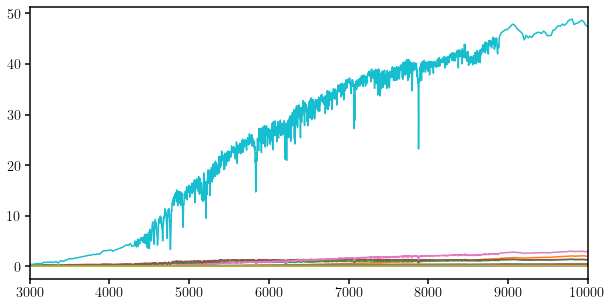

In [6]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for w, f in zip(wave_obs, flux_obs):
    sub.plot(w, f)
sub.set_xlim(3e3, 1e4)

In [7]:
desi_mcmc = Infer.desiMCMC(model=m_nmf, prior=prior)

In [ ]:
chains = []
for i in range(len(theta_obs)):
    print('true theta = ', theta_obs[i])
    zeus_chain = desi_mcmc.run(
        wave_obs=wave_obs[i], 
        flux_obs=flux_obs[i], 
        flux_ivar_obs=np.ones(wave_obs[i].shape),
        zred=z_obs, 
        sampler='zeus',
        theta_start=prior.untransform(theta_obs[i]),
        nwalkers=30, 
        burnin=100,
        opt_maxiter=2000,
        niter=100, 
        debug=True)
    chains.append(zeus_chain)

    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)
    sub.plot(wave_obs[i], flux_obs[i])
    sub.plot(zeus_chain['wavelength_obs'], zeus_chain['flux_spec_model'], c='k', ls=':')
    sub.set_xlim(3e3, 1e4)

    flat_chain = desi_mcmc._flatten_chain(zeus_chain['mcmc_chain'])

    _ = DFM.corner(flat_chain, bin=20, smooth=True, truths=theta_obs[i])

true theta =  [9.51027161e+00 1.97057761e-01 6.49573855e-01 7.23183968e-02
 8.10499874e-02 3.00490168e-03 4.96036125e-03 1.27354490e+00
 1.63210113e+00 3.56088825e-01]
--- initializing the walkers ---


/Users/chahah/projects/provabgs/src/provabgs/models.py:838: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
Initialising ensemble of 30 walkers...


initial theta = [9.510271610496465, 0.8029422389836555, 0.1910079912714865, 0.528466070901048, 0.003004901682846831, 0.004960361250625078, 1.2735449000548345, 1.632101133564865, 0.35608882501232175]
log Posterior(theta0) = -0.006059
--- burn-in ---


/Users/chahah/projects/provabgs/src/provabgs/models.py:838: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
Sampling progress : 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]
Initialising ensemble of 30 walkers...


--- running main MCMC ---


Sampling progress : 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


bestfit theta = [9.518107732523799, 0.3341361636462459, 0.3064441160903365, 0.07513896454497361, 0.284280755718444, 0.005249653964325025, 0.0012212699189825147, 2.814241516060902, 1.7644275148516597, 0.3629799249006989]
log Posterior = -0.008651
Model.sed: redshift = 0.200000
Model.sed: ssp lum [ 1955.87011264  1809.06931782  1384.51163064 ... 34997.73793158
 34722.99941898 34716.82984179]


/Users/chahah/projects/provabgs/src/provabgs/models.py:838: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
Initialising ensemble of 30 walkers...


true theta =  [ 1.06718694e+01  2.78182497e-01  5.64127849e-01  1.54990401e-01
  2.69925230e-03  2.14776809e-03  6.89773568e-03  6.20654180e-01
  2.97189718e+00 -1.50740741e+00]
--- initializing the walkers ---
initial theta = [10.67186939583566, 0.7218175025113936, 0.2184619424545824, 0.01711749780790406, 0.0021477680874801056, 0.006897735679820875, 0.6206541803927569, 2.971897175163661, -1.5074074147632506]
log Posterior(theta0) = -0.254519
--- burn-in ---


Sampling progress :  18%|█▊        | 18/100 [00:15<00:59,  1.38it/s]

(3000.0, 10000.0)

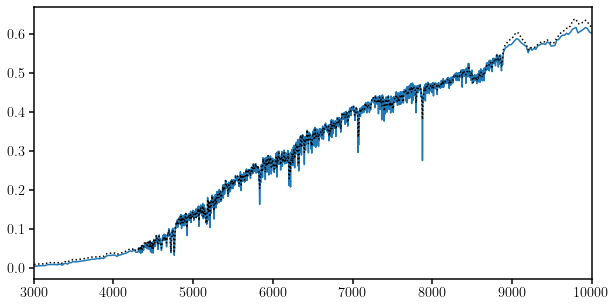

In [22]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(wave_obs[0], flux_obs[0])
sub.plot(zeus_chain['wavelength_obs'], zeus_chain['flux_spec_model'], c='k', ls=':')
sub.set_xlim(3e3, 1e4)

In [23]:
lnpost_args, lnpost_kwargs = desi_mcmc._lnPost_args_kwargs(
    wave_obs=wave_obs[0], flux_obs=flux_obs[0], flux_ivar_obs=np.ones(wave_obs[0].shape),
    zred=z_obs, vdisp=0, prior=prior)

In [24]:
print(desi_mcmc.lnPost(prior.untransform(theta_obs[0]), *lnpost_args, **lnpost_kwargs))
print(desi_mcmc.lnLike(theta_obs[0], *lnpost_args, **lnpost_kwargs, debug=True))

-0.0010829574507257357
Model.sed: redshift = 0.200000
Model.sed: ssp lum [   770.60760719    797.01395078    776.26876321 ... 220787.43643937
 218854.28465493 218730.0838046 ]
[-1.13386584e-04  7.21821042e-05  8.94996653e-06 ... -7.22144910e-04
  6.71126058e-04  9.42478964e-04]
desiMCMC.lnLike: Spectroscopic Chi2 = 0.002166
desiMCMC.lnLike: total Chi2 = 0.002166
-0.0010829574507257478


In [13]:
desi_mcmc.lnLike(theta_obs[0], *lnpost_args, **lnpost_kwargs, debug=True)

Model.sed: redshift = 0.200000
Model.sed: ssp lum [   770.60760719    797.01395078    776.26876321 ... 220787.43643937
 218854.28465493 218730.0838046 ]
[-1.13386584e-04  7.21821042e-05  8.94996653e-06 ... -7.22144910e-04
  6.71126058e-04  9.42478964e-04]
desiMCMC.lnLike: Spectroscopic Chi2 = 0.002166
desiMCMC.lnLike: total Chi2 = 0.002166


-0.0010829574507257478

In [18]:
desi_mcmc.lnPost(prior.untransform(zeus_chain['theta_bestfit']), *lnpost_args, **lnpost_kwargs)

-0.04073087702578852

In [19]:
flat_chain = desi_mcmc._flatten_chain(zeus_chain['mcmc_chain'])

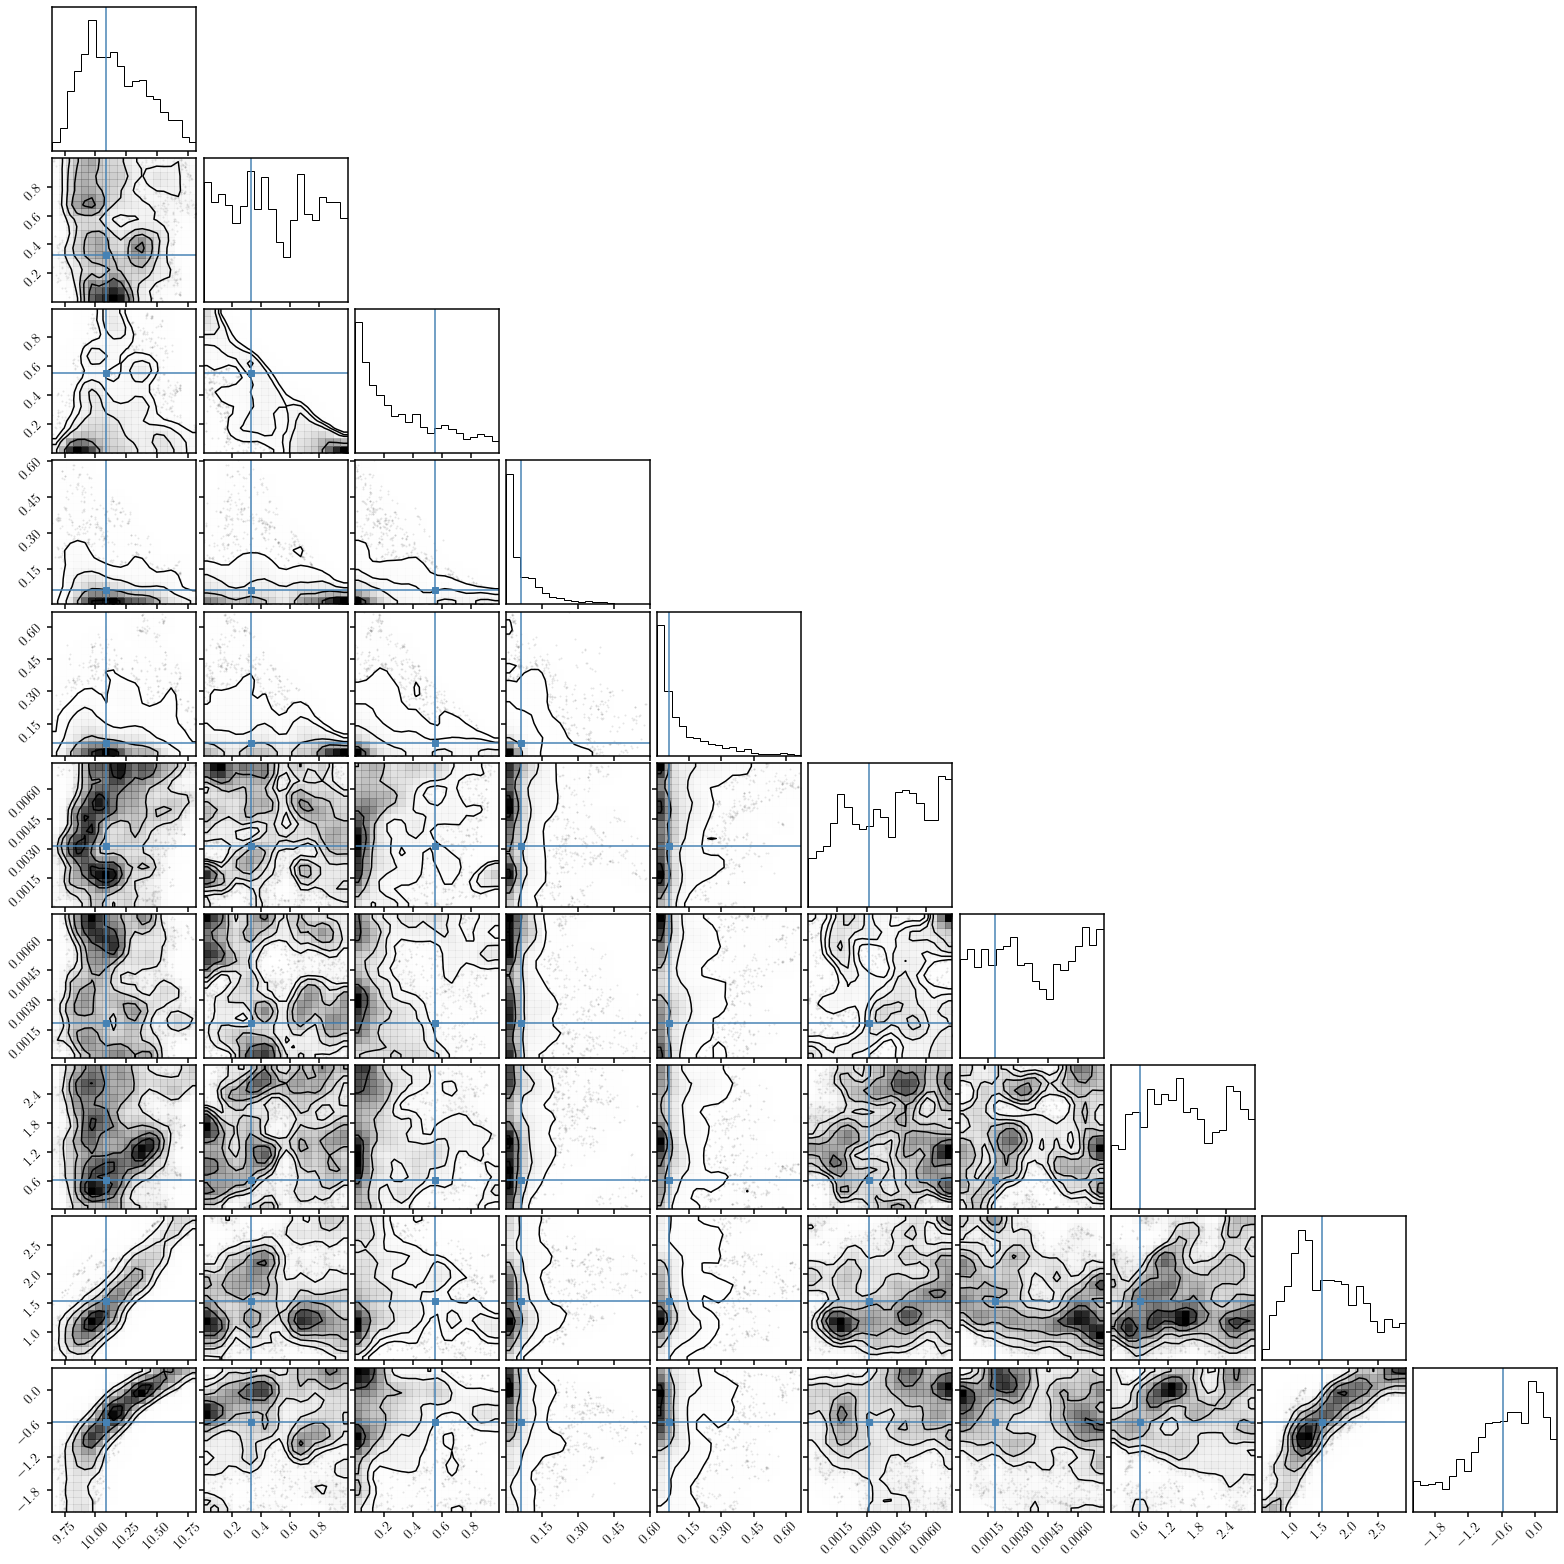

In [20]:
_ = DFM.corner(flat_chain, bin=20, smooth=True, truths=theta_obs[0])